This is probably a dumb idead but the ages have to be weighted by the volume over which they're computed 


Algorithm

    - Repeat for 1,000 steps:
        -Pick a volume parameter dt  --> look at the distribution of ages centered around (theta, dt)
        - Compute median age weighted by volume (assume theta ^3)
        - Save median age
        - Increase d theta
    - Return median ages weighted by the volume
    
    
    
   
Theta is a phase-space thing (position, velocit, actions, metallicity) 
Delta theta is a tunable parameter

As delta theta goes to infinity, prob --> 0
        

In [250]:
import quickage
import warnings
warnings.filterwarnings("ignore")

import astropy.coordinates as astro_coord
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
import math
#from astropy.constants im
%matplotlib inline
import pandas as pd

In [729]:
ross={'ra': 34.76599999999999,
              'dec':35.353388888888894,
              'pmra':(670.532, 0.042),
              'pmdec':( -427.412, 0.040),
              'distance':  (17.44, 0.012),
              'rv': (-27.80, 0.14)}

ross_metal= (-0.40, 0.12)

ross_age= (7.2, 3.7)

trapp={'ra': 346.6250957,
              'dec':-5.0428081,
              'pmra': (922.0 , 0.6),
              'pmdec': (-471.9, 0.9),
              'distance':  (12.49 , 0.18),
              'rv': (-51.688, 0.014)}
trapp_metal=(0.04 , 0.08)

trapp_age= (7.6, 2.2)

In [304]:
2.2/7.6

0.2894736842105263

In [254]:
def weighted_avg_and_std(values, weights):
    """
    Return the weighted average and standard deviation.

    values, weights -- Numpy ndarrays with the same shape.
    """
    #remove nans
    nans= np.logical_or(np.isnan(values), np.isnan(weights))
    values=values[~nans]
    weights=weights[~nans]
    average = np.average(values, weights=weights)
    # Fast and numerically precise:
    variance = np.average((values-average)**2, weights=weights)
    return (average, math.sqrt(variance))

In [671]:
data=quickage.load_galah_sample()

In [33]:
def get_xyz(source_coord, norbits=1000):
    Scoord={'ra':source_coord['ra'], \
              'dec': source_coord['dec'],\
              'pmra':np.random.normal(source_coord['pmra'][0],source_coord['pmra'][1], int(norbits)),
              'pmdec':np.random.normal(source_coord['pmdec'][0],source_coord['pmdec'][1], int(norbits)),
              'distance':np.random.normal(source_coord['distance'][0],source_coord['distance'][1], int(norbits)),
              'rv': np.random.normal(source_coord['rv'][0],source_coord['rv'][1], int(norbits))}

    source_coord, source_pos=quickage.get_phase_space(Scoord['ra'], 	Scoord['dec'],\
                       	Scoord['pmra']*np.cos(	Scoord['dec']*u.degree), \
                       	Scoord['pmdec'], 	Scoord['distance'], Scoord['rv'])
    
    return  source_coord, source_pos

In [733]:
def draw_around(center, condition, data):
    #condition is a dictionary
    booleans=[]
    for k in condition.keys():
        booleans.append(np.abs(data[k]-center[k])<condition[k])
        
    comb_bool=np.logical_and.reduce(booleans)
    med= np.nanmedian(data.age1[comb_bool])
    unc= np.nanstd(data.age1[comb_bool])
    return med, unc

def compute_age_around(center, nsteps, additional_cuts=None):
    weights=[]
    samples=[]
    for d in tqdm(np.logspace(1, 3, nsteps)):
        for v in (np.logspace(1, 2*np.log10(3), nsteps)):
            w=1/(d**3*v**3)
            conds={'x':d,
               'y':d,
               'z':d,
               'v_x':v,
               'v_y':v,
               'v_z':v}
            
            if additional_cuts != None:
                for k in additional_cuts.keys(): conds[k]=additional_cuts[k]
                
            med, std=draw_around(center, conds, data)
            samples.append(np.random.normal(med, std, 1))
            weights.append(w)
    #normalize weights
    weights=np.array(weights)/np.nanmax(weights)
    return {'samples': np.array(samples), 'weights': np.array(weights)}

In [734]:
_,trap_s =get_xyz(trapp)
_, ross_s=get_xyz(ross)

In [735]:
for s in [ross_s ,]:
    center={'x':np.nanmean(s.x).to(u.pc).value,
           'y':np.nanmean(s.y).to(u.pc).value,
           'z':np.nanmean(s.z).to(u.pc).value,
           'v_x':np.nanmean(s.v_x).to(u.km/u.s).value,
           'v_y':np.nanmean(s.v_y).to(u.km/u.s).value,
           'v_z':np.nanmean(s.v_z).to(u.km/u.s).value,
            '[Fe/H]': 0.04 }

In [736]:
additional_cuts={'[Fe/H]': 0.1}

In [737]:
res=compute_age_around(center, 100, additional_cuts=additional_cuts)

100%|████████████████████████████████████████████████████████████████| 100/100 [01:04<00:00,  1.54it/s]


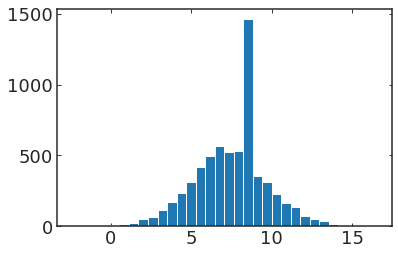

In [738]:
_= plt.hist(res['samples'].flatten(), bins=32)

In [739]:
#_=plt.hist(res['weights'], bins='auto', range=[1e-1, 1])

In [740]:
res['weights']

array([7.29000000e-01, 7.31331229e-01, 7.33669913e-01, ...,
       9.93634858e-07, 9.96812348e-07, 1.00000000e-06])

In [741]:
np.nanmedian(res['samples'].flatten()), np.nanstd(res['samples'].flatten())

(7.82869188939646, 2.2662149654109416)

In [649]:
trap_res=weighted_avg_and_std(res['samples'].flatten(), res['weights'])

In [275]:
trap_res= weighted_avg_and_std(res['samples'].flatten(), res['weights'])

In [634]:
def get_volume_weighted_age(source, source_metal, nsteps=20, additional_cuts=None):
    _,s =get_xyz(source)
    center={'x':np.nanmean(s.x).to(u.pc).value,
        'y':np.nanmean(s.y).to(u.pc).value,
        'z':np.nanmean(s.z).to(u.pc).value,
        'v_x':np.nanmean(s.v_x).to(u.km/u.s).value,
        'v_y':np.nanmean(s.v_y).to(u.km/u.s).value,
        'v_z':np.nanmean(s.v_z).to(u.km/u.s).value,
        '[Fe/H]': source_metal[0]}
    
    res=compute_age_around(center, nsteps, additional_cuts=additional_cuts)
    value, unc=weighted_avg_and_std(res['samples'].flatten(), res['weights'])
    return value, unc

In [679]:
def draw_random_star(select_by= ['metallicity', 'jz'], dataset='galah', nsample=1,\
                     nsigma=1, norbits=50, volume=10, velocity_volume=50):
    
    #draw a random star
    df= data.sample(n=nsample).reset_index(drop=True)
    
    res_df=[]
    for index, row in df.iterrows():
        try:
            dist= 1000/np.random.normal(row.plx,row.eplx,  1000)

            sourc={'ra': row.ra_gaia, \
                      'dec': row.de_gaia,
                      'pmra':( row.pmracosdec, np.abs(0.1*row.pmracosdec)),
                      'pmdec':(row.pmde,  np.abs(0.1*row.pmde)),
                      'distance': (np.nanmedian(dist), np.nanstd(dist)),
                      'rv':(row['rv'], 0.1*np.abs(row['er_rv']))}
                   
            metal=(row['[Fe/H]'] , np.abs(row['er[Fe/H]']))

            additional_cuts={'[Fe/H]': metal[-1]}
            
            med, unc=get_volume_weighted_age(sourc, metal, nsteps=50, additional_cuts=additional_cuts)

            res_df.append({'real': row.age1,
                           'real_unc': [row.l_age1, row.u_age1],
                   'res_median': med ,
                    'res_unc': unc})
        except:
            pass
    return pd.DataFrame.from_records(res_df)

In [743]:
%%capture
x= draw_random_star(nsample=5)

In [716]:
np.nanmedian(np.abs(np.vstack(x.real_unc.values).T-x.real.values))

1.7363616241264923

In [717]:
np.nanmedian(np.vstack(x.res_unc.values))

2.238389955565658

In [745]:
x.to_csv('../data_weighted_ages_metcuts_validation.txt', index=False)

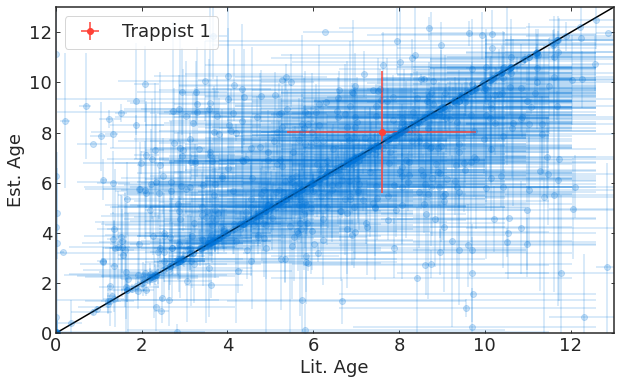

In [744]:
fig, ax=plt.subplots(figsize=(10, 6))

ax.errorbar(x['real'], x['res_median'], xerr=np.abs(np.vstack(x.real_unc.values).T-x.real.values), \
            yerr=x.res_unc.values,  fmt='o',\
            c='#0074D9', ecolor = '#0074D9', alpha=0.2)


#ax.errorbar(ross_age[0], ross_res[0], xerr= ross_age[1], yerr= ross_res[1],
#            fmt='o', c='#FF851B', ecolor = '#FF851B', label='ROSS 19')

ax.errorbar(trapp_age[0], trap_res[0], xerr= trapp_age[1], yerr= trap_res[1],\
            fmt='o', c='#FF4136', ecolor = '#FF4136', label='Trappist 1')

ax.legend()
ax.plot([0., 13], [0, 13], c='k')
ax.set(xlim=[0, 13], ylim=[0, 13])
ax.set(xlabel='Lit. Age', ylabel='Est. Age')
plt.savefig('weighted_ages_metcuts.jpeg')

In [494]:
data['abs_z']=np.abs(data.z.values)/1000

In [495]:
data['abs_z'].min(), data['abs_z'].max()

(6.34702465e-06, 65.09645427091)